In [127]:
from tcia_utils import nbia
import sys
!{sys.executable} -m pip install --upgrade -q tcia_utils

import requests
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

from concurrent.futures import ThreadPoolExecutor

import json
import urllib
from io import StringIO

import pydicom
import os
import random
import matplotlib.pyplot as plt

import openslide

# 1. CT scans

cart_link = "https://nbia.cancerimagingarchive.net/nbia-search/?saved-cart=nbia-32381737914700927"

In [27]:
# TCGA_collections = [collection for collection in nbia.getCollections() if collection["Collection"].startswith("TCGA")]
# metadata = nbia.getSeries(collection = "TCGA-KIRC")

# data_ct_scans_path = config["paths"]["ct_scans_path"]

# cart_id = "nbia-32381737914700927"
# data_CT_scans = nbia.getSharedCart(name = cart_id)
# print(len(data_CT_scans), 'Series returned')

# df = nbia.downloadSeries(data_CT_scans, path=data_ct_scans_path, format = "csv")
# display(df)

In [28]:
# download a chunk of series and return metadata
def download_and_collect_metadata(chunk, output_path):
    return nbia.downloadSeries(chunk, path=output_path, format="df")

data_ct_scans_path = config["datapaths"]["ct_scans_path"]
num_threads = 4  # system capacity

data_CT_scans = nbia.getSharedCart(name = cart_id)
print(len(data_CT_scans), 'Series returned')

#split the data into smaller chunks
chunk_size = len(data_CT_scans) // num_threads
chunks = [data_CT_scans[i:i + chunk_size] for i in range(0, len(data_CT_scans), chunk_size)]

# Parallel downloads and metadata collection
output_path = data_ct_scans_path
dfs = []  # tTo store DataFrames from each chunk

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(download_and_collect_metadata, chunk, output_path) for chunk in chunks]
    for future in futures:
        dfs.append(future.result())

# combine all individual DataFrames into one
metadata_ct_scans = pd.concat(dfs, ignore_index=True)
metadata_ct_scans.to_csv(f"{output_path}/metadata_ct_scans.csv", index=False)

2025-01-26 12:22:29,934:INFO:Calling getContentsByName with parameters {'name': 'nbia-32381737914700927'}
2025-01-26 12:22:30,347:INFO:Downloading 5 out of 5 Series Instance UIDs (scans).
2025-01-26 12:22:30,351:INFO:Downloading 5 out of 5 Series Instance UIDs (scans).
2025-01-26 12:22:30,351:INFO:Downloading 5 out of 5 Series Instance UIDs (scans).
2025-01-26 12:22:30,355:INFO:Directory 'D:/data/ct_scans' already exists.
2025-01-26 12:22:30,358:INFO:Downloading 5 out of 5 Series Instance UIDs (scans).
2025-01-26 12:22:30,358:INFO:Directory 'D:/data/ct_scans' already exists.
2025-01-26 12:22:30,358:INFO:Directory 'D:/data/ct_scans' already exists.
2025-01-26 12:22:30,358:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.119051745938678655108860595562 already downloaded and unzipped.
2025-01-26 12:22:30,358:INFO:Directory 'D:/data/ct_scans' already exists.
2025-01-26 12:22:30,358:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.235372221968123637436536429205 already downloaded and unzipp

23 Series returned


2025-01-26 12:22:30,623:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.153715743594716522671526792606 already downloaded and unzipped.
2025-01-26 12:22:30,629:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.271703816829795254742813110061 already downloaded and unzipped.
2025-01-26 12:22:30,655:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.8421.4004.175115269159141181565296394326 already downloaded and unzipped.
2025-01-26 12:22:30,656:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.400524505778524709531211467468 already downloaded and unzipped.
2025-01-26 12:22:30,875:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.277496443283218875628630256275 already downloaded and unzipped.
2025-01-26 12:22:30,891:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.180964259361360923441936969293 already downloaded and unzipped.
2025-01-26 12:22:30,895:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.8421.4004.187310743962446536351224828157 already downloaded and unzipped.
2025-01-26 12:22:30,912:WARNING:Series 1.

- Two subjects
- Subject 1 has 16 series
    - Each series has multiple images
    - Each series may represent different purposes => need to check
- Subject 2 has 7 series
    - Each series has multiple images
    - Each series may represent different purposes => need to check

In [30]:
metadata_ct_scans.head()

,Series UID,Collection,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,...,License URL,Annotation Size,Date Released,Series Date,Protocol Name,Body Part Examined,Annotations Flag,Manufacturer Model Name,Software Versions,TimeStamp
0,1.3.6.1.4.1.14519.5.2.1.6450.4004.119051745938...,TCGA-KIRC,https://doi.org/10.7937/K9/TCIA.2016.V6PBVTDR,TCGA-B0-5085,1.3.6.1.4.1.14519.5.2.1.6450.4004.158131485447...,MRI ABDOMEN WWO CONTR,07-05-1987,ax ssfse,GE MEDICAL SYSTEMS,MR,...,http://creativecommons.org/licenses/by/3.0/,0,Thu Dec 13 11:57:43 UTC 2012,Sun Jul 05 00:00:00 UTC 1987,UPMC RENAL MASS/,KIDNEY,false,SIGNA EXCITE,11,Thu Dec 13 11:57:43 UTC 2012
1,1.3.6.1.4.1.14519.5.2.1.6450.4004.153715743594...,TCGA-KIRC,https://doi.org/10.7937/K9/TCIA.2016.V6PBVTDR,TCGA-B0-5085,1.3.6.1.4.1.14519.5.2.1.6450.4004.158131485447...,MRI ABDOMEN WWO CONTR,07-05-1987,3d fame Special,GE MEDICAL SYSTEMS,MR,...,http://creativecommons.org/licenses/by/3.0/,0,Thu Dec 13 11:58:40 UTC 2012,Sun Jul 05 00:00:00 UTC 1987,UPMC RENAL MASS/,KIDNEY,false,SIGNA EXCITE,11,Thu Dec 13 11:58:40 UTC 2012
2,1.3.6.1.4.1.14519.5.2.1.6450.4004.180964259361...,TCGA-KIRC,https://doi.org/10.7937/K9/TCIA.2016.V6PBVTDR,TCGA-B0-5085,1.3.6.1.4.1.14519.5.2.1.6450.4004.336105265862...,e1 AP,06-18-1987,NaN,GE MEDICAL SYSTEMS,CT,...,http://creativecommons.org/licenses/by/3.0/,0,Thu Dec 13 11:01:13 UTC 2012,Thu Jun 18 00:00:00 UTC 1987,6.13 A/P W/O & W,KIDNEY,false,LightSpeed QX/i,LightSpeedApps10.5_2.8.2I_H1.3M4,Thu Dec 13 11:01:13 UTC 2012
3,1.3.6.1.4.1.14519.5.2.1.6450.4004.181634329297...,TCGA-KIRC,https://doi.org/10.7937/K9/TCIA.2016.V6PBVTDR,TCGA-B0-5085,1.3.6.1.4.1.14519.5.2.1.6450.4004.911144113020...,AP WWO,07-14-1987,NaN,GE MEDICAL SYSTEMS,CT,...,http://creativecommons.org/licenses/by/3.0/,0,Thu Dec 13 11:17:58 UTC 2012,Tue Jul 14 00:00:00 UTC 1987,6.14 KIDNEY MASS,KIDNEY,false,LightSpeed Ultra,LightSpeedApps308I.2_H3.1M5,Thu Dec 13 11:17:58 UTC 2012
4,1.3.6.1.4.1.14519.5.2.1.6450.4004.186509605806...,TCGA-KIRC,https://doi.org/10.7937/K9/TCIA.2016.V6PBVTDR,TCGA-B0-5085,1.3.6.1.4.1.14519.5.2.1.6450.4004.158131485447...,MRI ABDOMEN WWO CONTR,07-05-1987,ax inout phase,GE MEDICAL SYSTEMS,MR,...,http://creativecommons.org/licenses/by/3.0/,0,Thu Dec 13 11:57:55 UTC 2012,Sun Jul 05 00:00:00 UTC 1987,UPMC RENAL MASS/,KIDNEY,false,SIGNA EXCITE,11,Thu Dec 13 11:57:55 UTC 2012


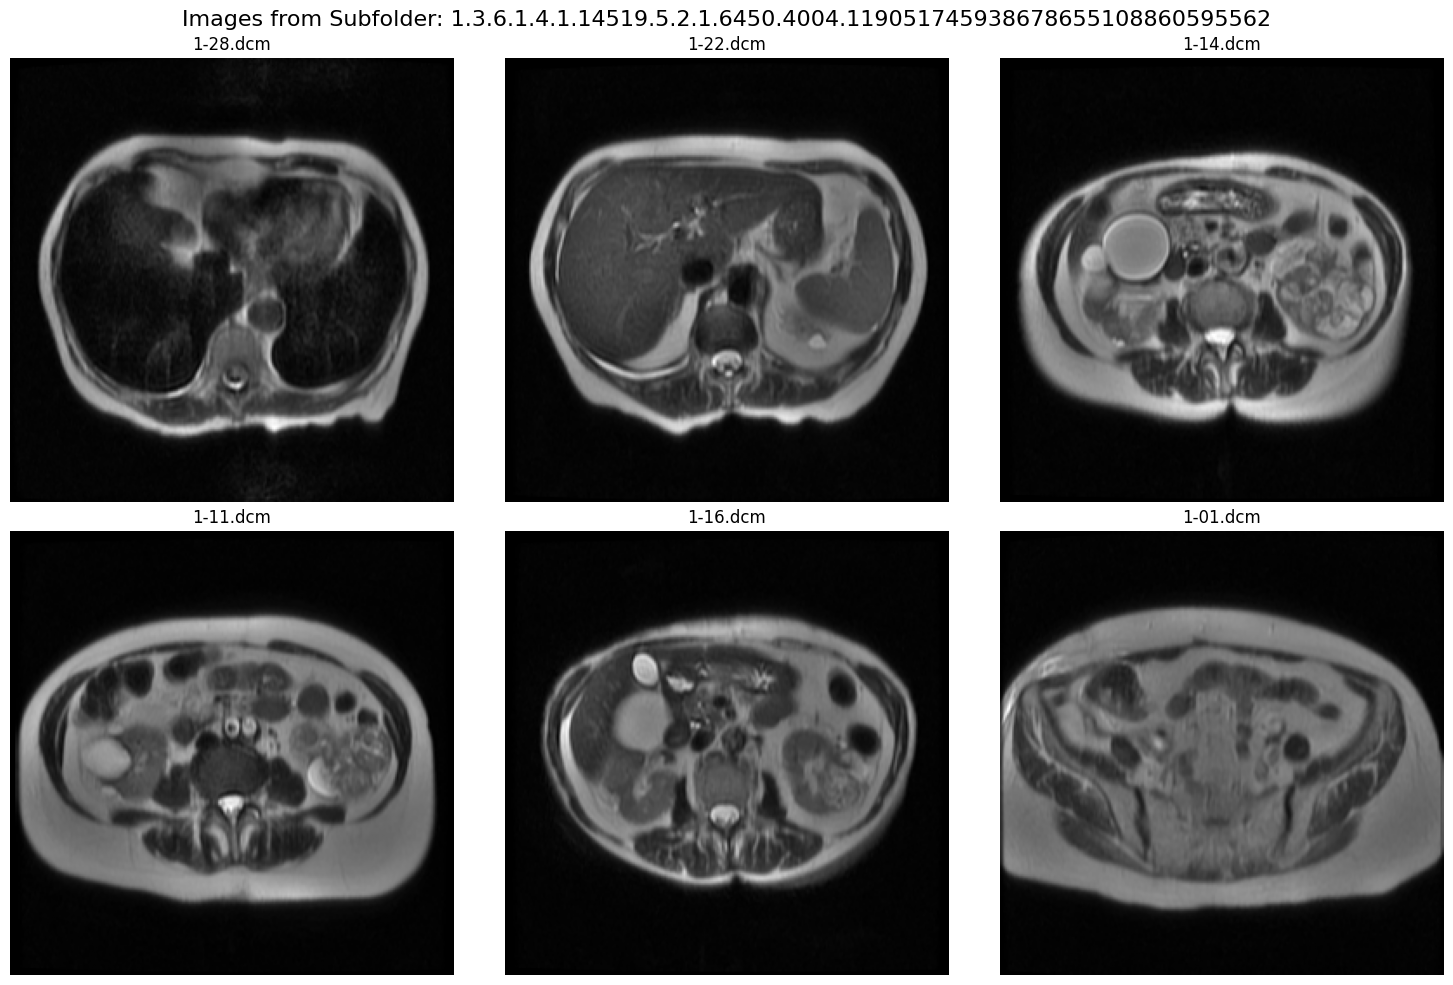

In [103]:
# Define the folder path
folder_path = config["datapaths"]["ct_scans_path"]

def display_dicom_grid(image_paths, subfolder_name):
    """Displays a grid of DICOM images."""
    num_images = len(image_paths)
    cols = 3  # Number of columns in the grid
    rows = (num_images + cols - 1) // cols  # Calculate the required number of rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, image_path in enumerate(image_paths):
        dicom_data = pydicom.dcmread(image_path)
        axes[i].imshow(dicom_data.pixel_array, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(os.path.basename(image_path))
    
    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.suptitle(f"Images from Subfolder: {subfolder_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

def process_subfolder(subfolder_path):
    """Processes a subfolder to print DICOM images in a grid."""
    # Get all files in the subfolder
    files = [os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.endswith('.dcm')]
    
    if not files:
        print(f"No DICOM files in {subfolder_path}.")
        return
    
    # Select 6 random images or all if less than 6
    selected_files = random.sample(files, min(len(files), 6))
    
    # Display the images in a grid
    subfolder_name = os.path.basename(subfolder_path)
    display_dicom_grid(selected_files, subfolder_name)

# Iterate through each subfolder in the main folder
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        process_subfolder(subfolder_path)
    break


# 2. Clinical

In [104]:
case_ids = ["TCGA-B8-A54E", "TCGA-B0-5085"]

def queryBuilder(endpoint, filters, fields, size, frmat):
    api_url = 'https://api.gdc.cancer.gov/'
    
    if frmat.lower() == 'json':
        request_query = api_url + endpoint + '?filters=' + filters + '&fields=' + fields + '&size=' + size + '&format=' + frmat + '&pretty=true'
    else:
        request_query = api_url + endpoint + '?filters=' + filters + '&fields=' + fields + '&size=' + size + '&format=' + frmat
    return request_query


#step 1: specify and encode filters
combination_two = {
    "op" : "and",
    "content":[{
        "op":"=",
         "content":{
              "field": "cases.project.project_id", 
                "value": "TCGA-KIRC"
            }
        }, 
        {
            "op":"=", 
            "content":{
                "field":"submitter_id",
                "value": case_ids
            }
        }
    ]
}

json_string=str(json.dumps(combination_two))
filters_format = urllib.parse.quote(json_string.encode('utf-8'))

#step 2: specify fields to be returned
fields = ",".join([
    "submitter_id",
    "demographic.age_at_index", "demographic.cause_of_death", "demographic.days_to_death",
    "demographic.ethnicity", "demographic.gender",
    "demographic.race", "demographic.vital_status", "demographic.year_of_death",
    "diagnoses.ajcc_clinical_m", "diagnoses.ajcc_clinical_n", "diagnoses.ajcc_clinical_stage",
    "diagnoses.ajcc_clinical_t", "diagnoses.ajcc_pathologic_m", "diagnoses.ajcc_pathologic_n",
    "diagnoses.ajcc_pathologic_stage", "diagnoses.ajcc_pathologic_t", 
    "diagnoses.days_to_last_follow_up", "diagnoses.year_of_diagnosis", 
    "diagnoses.days_to_last_follow_up", 
    "diagnoses.progression_or_recurrence"
])

#step 3+4: specify size=2 and format=tsv, build query url with 'cases' endpoint
template = queryBuilder('cases', filters_format, fields, '2', "tsv")

#step 5: send request
content = requests.get(template)

data = StringIO(content.text)
df = pd.read_csv(data, sep="\t")
output_path = config["datapaths"]["clinical_path"]
df.to_csv(f"{output_path}/metadata_clinical.csv", index=False)

In [92]:
schema_endpoint = "https://api.gdc.cancer.gov/files/_mapping"
response = requests.get(schema_endpoint)
schema = response.json()
with open("available_fields_for_files.txt", "w") as file:
    file.write("Available fields for files:\n\n")
    for field in schema["fields"]:
        file.write(f"{field}\n")

In [91]:
df["time"] = df.apply(
    lambda row: row["demographic.days_to_death"]
    if row["demographic.vital_status"] == "Dead"
    else row["diagnoses.0.days_to_last_follow_up"],
    axis=1,
)
df

,demographic.age_at_index,demographic.days_to_death,demographic.ethnicity,demographic.gender,demographic.race,demographic.vital_status,demographic.year_of_death,diagnoses.0.ajcc_clinical_m,diagnoses.0.ajcc_pathologic_m,diagnoses.0.ajcc_pathologic_n,diagnoses.0.ajcc_pathologic_stage,diagnoses.0.ajcc_pathologic_t,diagnoses.0.days_to_last_follow_up,diagnoses.0.progression_or_recurrence,diagnoses.0.year_of_diagnosis,id,submitter_id,time
0,62,NaN,hispanic or latino,female,black or african american,Alive,NaN,M0,MX,NX,Stage I,T1b,909.0,not reported,2011,59d18f0c-946f-4850-892f-70e2bf380232,TCGA-B8-A54E,909.0
1,76,770.0,not hispanic or latino,female,white,Dead,2007.0,NaN,M0,N0,Stage III,T3a,NaN,not reported,2005,62c6edc7-170d-4825-ab81-f88b14013cc5,TCGA-B0-5085,770.0


- Are these variables good enough for clinical data? Look at all available fields for cases text file
- Is this correct way to derive the time and event variables for the Cox model?

# 3. Genomics

Under "files" in "available_fields_for_cases" OR "available_fields_for_files", I'm not sure yet

https://docs.gdc.cancer.gov/API/Users_Guide/Search_and_Retrieval/#post-example

# 4. WSIs

Might be using `slide_id` or something under "files" fields

In [105]:
# Function to query the GDC API for slide files associated with a submitter_id
def query_gdc_api(submitter_id):
    files_endpt = "https://api.gdc.cancer.gov/files"
    filters = {
        "op": "and",
        "content": [
            {
                "op": "in",
                "content": {
                    "field": "cases.submitter_id",
                    "value": [submitter_id]
                }
            },
            {
                "op": "in",
                "content": {
                    "field": "files.data_format",
                    "value": ["SVS"]
                }
            }
        ]
    }
    params = {
        "filters": json.dumps(filters),
        "fields": "file_id,file_name",
        "format": "JSON",
        "size": "100"
    }
    response = requests.get(files_endpt, params=params)
    if response.status_code == 200:
        return response.json()["data"]["hits"]
    else:
        print(f"Error querying GDC API: {response.status_code}")
        return []

# Function to download a file from the GDC API using its file_id
def download_slide(file_id, file_name, download_dir):
    data_endpt = f"https://api.gdc.cancer.gov/data/{file_id}"
    response = requests.get(data_endpt, stream=True)
    if response.status_code == 200:
        file_path = os.path.join(download_dir, file_name)
        with open(file_path, "wb") as output_file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    output_file.write(chunk)
        print(f"Downloaded {file_name}")
    else:
        print(f"Error downloading {file_name}: {response.status_code}")

# Main function to execute the download process
def main(submitter_id, download_dir, num_slides=2):
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # Query the GDC API for slide files
    slides = query_gdc_api(submitter_id)

    if not slides:
        print("No slides found for the given submitter_id.")
        return

    # Randomly select the specified number of slides
    selected_slides = random.sample(slides, min(num_slides, len(slides)))

    # Download each selected slide
    for slide in selected_slides:
        download_slide(slide["file_id"], slide["file_name"], download_dir)

if __name__ == "__main__":
    download_dir = "./"  # Replace with your desired download directory
    main(config["examples"]["subject_1"], download_dir)


Downloaded TCGA-B8-A54E-01Z-00-DX1.336165F7-BBAC-4FA8-B776-E12483C60B62.svs
Downloaded TCGA-B8-A54E-01A-01-TS1.287E393E-BE65-46F4-BB17-171DC9E825B1.svs


Available levels and their dimensions: ((91392, 21773), (22848, 5443), (5712, 1360), (2856, 680))
Image dimensions at level 0: (91392, 21773)


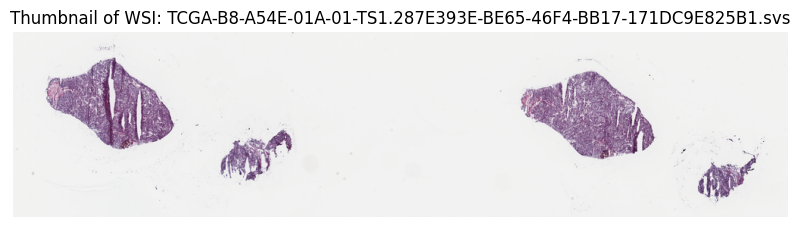

Available levels and their dimensions: ((185639, 68935), (46409, 17233), (11602, 4308), (2900, 1077))
Image dimensions at level 0: (185639, 68935)


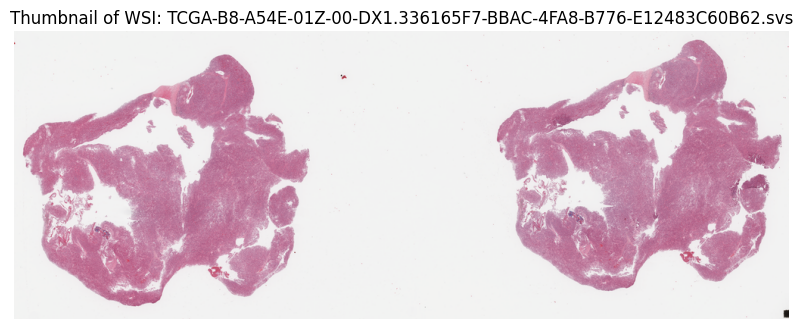

In [128]:

level = 0

file_path_1 = r"D:/data/wsi_slides/TCGA-B8-A54E-01A-01-TS1.287E393E-BE65-46F4-BB17-171DC9E825B1.svs"
file_path_2 = r"D:/data/wsi_slides/TCGA-B8-A54E-01Z-00-DX1.336165F7-BBAC-4FA8-B776-E12483C60B62.svs"


for file_path in [file_path_1, file_path_2]:
    try:
        # Open the SVS file
        slide = openslide.OpenSlide(file_path)

        # Get all level dimensions
        levels = slide.level_dimensions
        print(f"Available levels and their dimensions: {levels}")

        # Ensure the requested level is valid
        if level >= len(levels):
            raise ValueError(f"Level {level} is not valid. Available levels: {len(levels)}.")

        # Get the dimensions of the specified level
        dimensions = levels[level]
        print(f"Image dimensions at level {level}: {dimensions}")

        # Generate a thumbnail for easier visualization if the level is too large
        if dimensions[0] > 20000 or dimensions[1] > 20000:  # Arbitrary threshold
            thumbnail = slide.get_thumbnail((1024, 1024))  # Resize to 1024x1024
            plt.figure(figsize=(10, 10))
            plt.imshow(thumbnail)
            plt.axis("off")
            plt.title(f"Thumbnail of WSI: {file_path.split('/')[-1]}")
            plt.show()
        else:
            # Read the region of interest at the specified level
            region = slide.read_region((0, 0), level, dimensions)

            # Display the extracted region
            plt.figure(figsize=(10, 10))
            plt.imshow(region)
            plt.axis("off")
            plt.title(f"WSI: {file_path.split('/')[-1]} (Level {level})")
            plt.show()

    except Exception as e:
        print(f"Error displaying WSI: {e}")



In [124]:
for i, k in slide.properties.items():
    print(i, k)


aperio.AppMag 40
aperio.DSR ID 152.19.62.167
aperio.Date 11/19/12
aperio.DisplayColor 0
aperio.Exposure Scale 0.000001
aperio.Exposure Time 109
aperio.Filename 11-1041-2
aperio.Focus Offset 0.000000
aperio.ICC Profile ScanScope v1
aperio.ImageID 311102
aperio.Left 18.174372
aperio.LineAreaXOffset 0.014212
aperio.LineAreaYOffset -0.004733
aperio.LineCameraSkew 0.001417
aperio.MPP 0.2472
aperio.OriginalHeight 69035
aperio.OriginalWidth 193440
aperio.ScanScope ID SS1475
aperio.StripeWidth 992
aperio.Time 19:41:42
aperio.Time Zone GMT-05:00
aperio.Title Mag = 40X, compression quality =30
aperio.Top 21.537785
aperio.User 8ce982e3-6ea2-4715-8af3-9874e823e6d9
openslide.associated.thumbnail.height 380
openslide.associated.thumbnail.width 1024
openslide.comment Aperio Image Library vFS90 01
193440x69035 [0,100 185639x68935] (256x256) JPEG/RGB Q=30|AppMag = 40|StripeWidth = 992|ScanScope ID = SS1475|Filename = 11-1041-2|Title = Mag = 40X, compression quality =30|Date = 11/19/12|Time = 19:41:42|T